In [1]:
import os
import shutil
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_images(path, target_shape=(256, 256)):
    images = []
    try:
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path)
            
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            img = img.resize(target_shape)
            img = np.array(img)
            if img.shape == target_shape + (3,):  
                images.append(img)
            else:
                print(f"Ignoring image {filename} due to incorrect shape: {img.shape}")
    except Exception as e:
        print(f"Error loading images from {path}: {str(e)}")
    return images


source_base_dir = '/kaggle/input/image-pro/Image_Processing'
base_dir = '/kaggle/working/'
original_dir = os.path.join(source_base_dir, 'Original')
pixelated_dir = os.path.join(source_base_dir, 'Pixelated')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


os.makedirs(os.path.join(train_dir, 'Original'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'Pixelated'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Original'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Pixelated'), exist_ok=True)

2024-07-03 19:46:58.351148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 19:46:58.351295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 19:46:58.504497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def split_data(original_dir, pixelated_dir, train_dir, test_dir, split_ratio):
    original_files = os.listdir(original_dir)
    pixelated_files = os.listdir(pixelated_dir)
    
    paired_files = [(file, file) for file in original_files if file in pixelated_files]

    random.shuffle(paired_files)
    split_index = int(len(paired_files) * split_ratio)
    train_files = paired_files[:split_index]
    test_files = paired_files[split_index:]

    for original_file, pixelated_file in train_files:
        shutil.copy(os.path.join(original_dir, original_file), os.path.join(train_dir, 'Original', original_file))
        shutil.copy(os.path.join(pixelated_dir, pixelated_file), os.path.join(train_dir, 'Pixelated', pixelated_file))
    
    for original_file, pixelated_file in test_files:
        shutil.copy(os.path.join(original_dir, original_file), os.path.join(test_dir, 'Original', original_file))
        shutil.copy(os.path.join(pixelated_dir, pixelated_file), os.path.join(test_dir, 'Pixelated', pixelated_file))

split_ratio = 0.8
split_data(original_dir, pixelated_dir, train_dir, test_dir, split_ratio)

In [3]:
original_images = load_images(os.path.join(train_dir, 'Original'))
pixelated_images = load_images(os.path.join(train_dir, 'Pixelated'))

original_images = np.array(original_images).astype('float32') / 255.0
pixelated_images = np.array(pixelated_images).astype('float32') / 255.0

X_train, X_val, y_train, y_val = train_test_split(pixelated_images, original_images, test_size=0.2, random_state=42)

In [4]:
from tensorflow.keras.models import load_model

srcnn_model = load_model('/kaggle/input/srcnn-66-model/deeper_srcnn_model.h5')

In [5]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00


In [6]:
import numpy as np
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import lpips
import torch


loss_fn = lpips.LPIPS(net='alex')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 145MB/s]


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [7]:
def calculate_fps(model, images, num_iterations=100):
    start_time = time.time()
    for _ in range(num_iterations):
        model.predict(images)
    end_time = time.time()
    total_time = end_time - start_time
    fps = num_iterations / total_time
    return fps


def calculate_psnr_ssim(y_true, y_pred, win_size=3, data_range=1.0):
    psnr_values = []
    ssim_values = []
    for true, pred in zip(y_true, y_pred):
        psnr_values.append(psnr(true, pred, data_range=data_range))
        ssim_values.append(ssim(true, pred, win_size=win_size, data_range=data_range, multichannel=True))
    return np.mean(psnr_values), np.mean(ssim_values)

def calculate_lpips(y_true, y_pred):
    lpips_values = []
    for true, pred in zip(y_true, y_pred):
        true_tensor = torch.tensor(true.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)
        pred_tensor = torch.tensor(pred.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)
        true_tensor = 2 * true_tensor - 1
        pred_tensor = 2 * pred_tensor - 1
        lpips_value = loss_fn(true_tensor, pred_tensor)
        lpips_values.append(lpips_value.item())
    return np.mean(lpips_values)

In [8]:
y_pred = srcnn_model.predict(X_val)


psnr_value, ssim_value = calculate_psnr_ssim(y_val, y_pred, win_size=3, data_range=1.0)
lpips_value = calculate_lpips(y_val, y_pred)


y_pred_classes = np.argmax(y_pred, axis=3)  
y_val_classes = np.argmax(y_val, axis=3)  
y_pred_flat = y_pred_classes.flatten()
y_val_flat = y_val_classes.flatten()

conf_matrix = confusion_matrix(y_val_flat, y_pred_flat)

precision = precision_score(y_val_flat, y_pred_flat, average='weighted')
recall = recall_score(y_val_flat, y_pred_flat, average='weighted')
f1 = f1_score(y_val_flat, y_pred_flat, average='weighted')
accuracy = accuracy_score(y_val_flat, y_pred_flat)

fps = calculate_fps(srcnn_model, X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step


In [9]:
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"FPS: {fps:.2f}")
print(f"PSNR: {psnr_value:.4f}")
print(f"SSIM: {ssim_value:.4f}")
print(f"LPIPS: {lpips_value:.4f}")

Confusion Matrix:
[[24821235  2317278  1118399]
 [ 4976834  4006857   548714]
 [ 6154774  1445251  6318562]]
Precision: 0.6853
Recall: 0.6797
F1 Score: 0.6632
Accuracy: 0.6797
FPS: 0.01
PSNR: 14.2312
SSIM: 0.4898
LPIPS: 0.5917


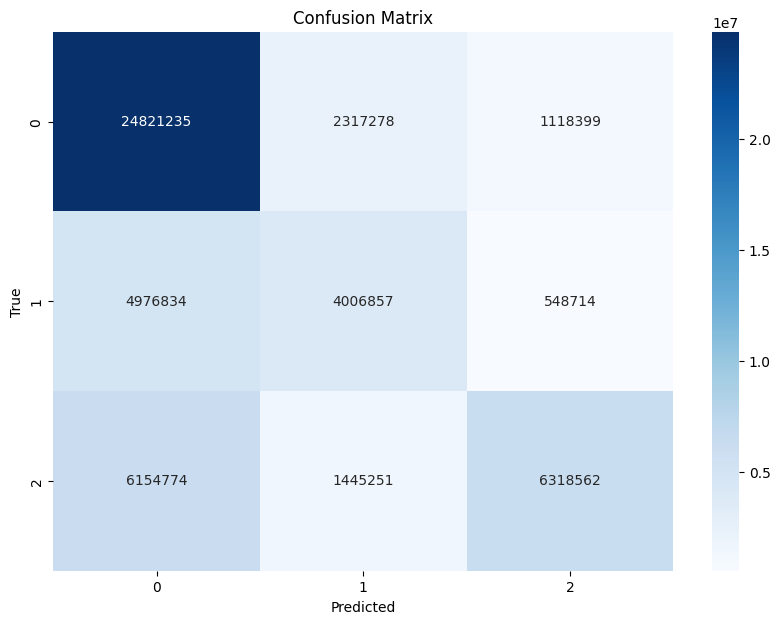

In [10]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()